#Import Libraries

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, models, transforms
from torch import nn, optim
import torch.nn.functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
import os
import copy

from torchvision.utils import make_grid
from torchsummary import summary
from sklearn import preprocessing

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:0


#Datasets

##MNIST

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

mnist_train = torchvision.datasets.MNIST(root='./mnist_data/',
                                         train=True,
                                         transform=transform,
                                         download=True)

mnist_test = torchvision.datasets.MNIST(root='./mnist_data/',
                                        train=False,
                                        transform=transform,
                                        download=False)

# create batches
mnist_train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 13162248.01it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 483598.79it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3779369.76it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5755446.76it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



##CIFAR10

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    ])

cifar10_train = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             download=True,
                                             transform=preprocess)

cifar10_test = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            download=True,
                                            transform=preprocess)

cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train, batch_size=64, shuffle=True)
cifar10_test_dataloader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 33973248.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


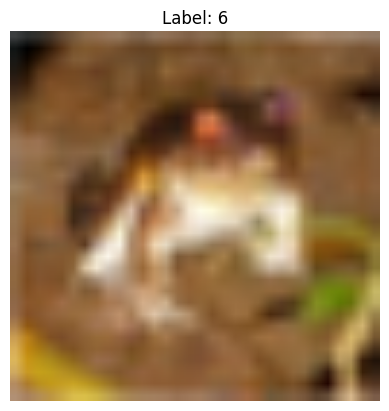

In [ ]:
# Get one image and label from the dataset
image, label = cifar10_train[0]

# Convert the tensor to a NumPy array for plotting
image = image.permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide the axes
plt.show()

# Generative Adversarial Network (GAN)

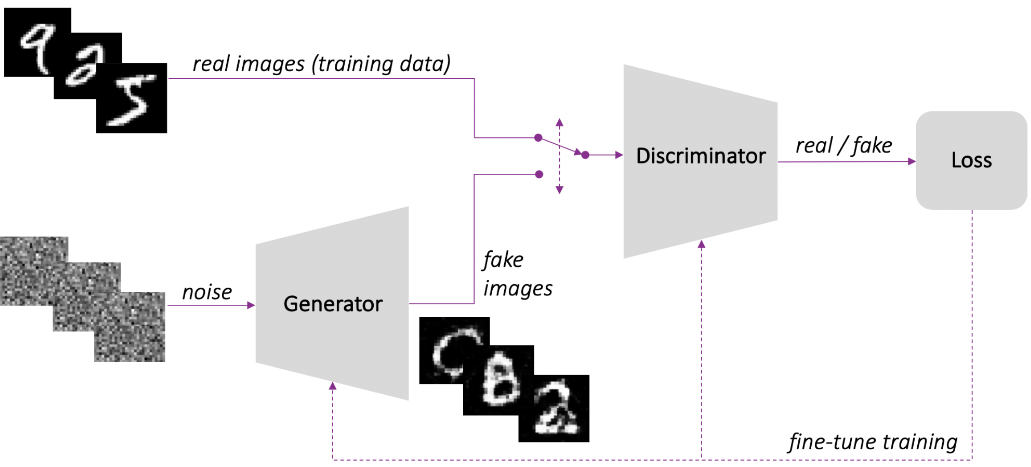

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,**kwargs):
        super(Discriminator,self).__init__(**kwargs)
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.net(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self,**kwargs):
        super(Generator,self).__init__(**kwargs)
        self.net = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh(),
        )
    def forward(self, batch_size):
        z = torch.randn(batch_size, 100).to(device)
        return self.net(z).view(-1, 28, 28)

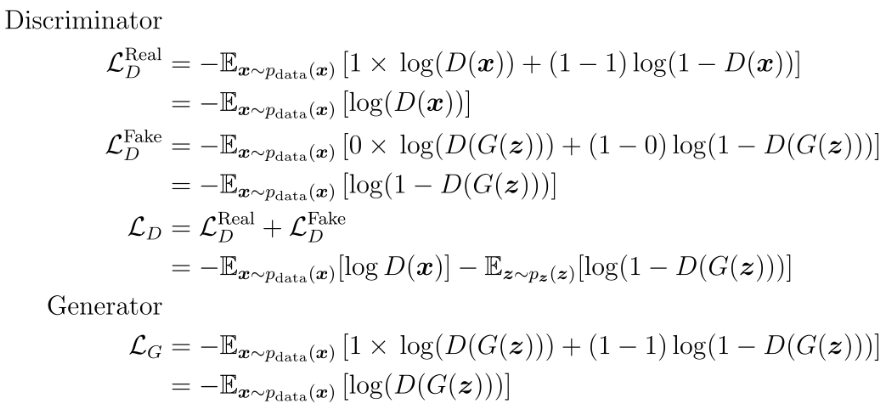

In [ ]:
def train_gan(
        dataloader,
        d_net,
        g_net,
        criterion = nn.BCELoss(),
        lr = 0.001,
        epochs = 1,
        optimizer = optim.Adam,
        ):

    d_optimizer = optimizer(d_net.parameters(), lr=lr)
    g_optimizer = optimizer(g_net.parameters(), lr=lr)

    for epoch in range(epochs):
        d_losses = []
        g_losses = []
        for images, labels in dataloader:
            batch_size = images.size(0)

            images = images.to(device)
            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)

            #...
            g_net.eval() #G(z)
            with torch.no_grad():
              generated_images = g_net(batch_size)

            #===============================
            # Discriminator Network Training
            #===============================
            #...
            d_net.train()
            d_loss = criterion(d_net(images),real_label) #L(real)
            d_loss += criterion(d_net(generated_images),fake_label) #L(fake)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            #===============================
            # Generator Network Training
            #===============================
            #...
            d_net.eval() #D(G(z))
            g_net.train()
            generated_images = g_net(batch_size)
            g_loss = criterion(d_net(generated_images), real_label)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        print(f"epoch:{epoch}, discriminator's loss:{np.mean(d_losses)}, generator's loss:{np.mean(g_losses)}")

        if (epoch)%5==0:
            #...
            g_net.eval()
            with torch.no_grad():
              fake = g_net(100)

            images = fake.detach().to('cpu').view(-1,1,28,28)
            images_grid = make_grid(images, nrow=10)
            plt.imshow(images_grid.permute(1, 2, 0).squeeze())
            plt.show()



            images_grid = make_grid(images, nrow=10)
            plt.imshow(images_grid.permute(1, 2, 0).squeeze())
            plt.show()

epoch:0, discriminator's loss:1.0578725939747622, generator's loss:2.5961161605012952


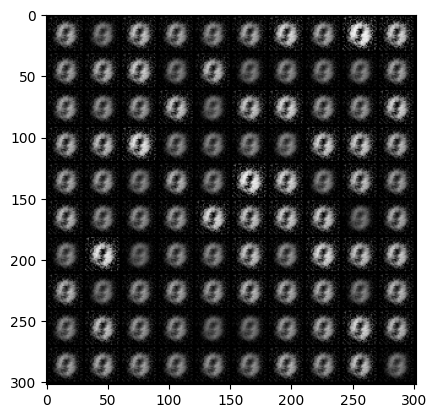

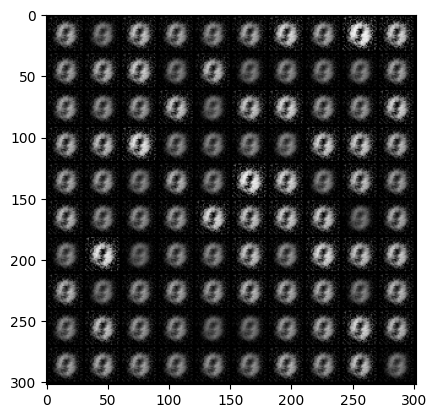

In [ ]:
#...
g_net = Generator().to(device)
d_net = Discriminator().to(device)

train_gan(dataloader=mnist_train_dataloader,
          d_net=d_net,
          g_net=g_net)

# mnist_train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
# mnist_test_dataloader = DataLoader(mnist_test, batch_size=64, shuffle=True)



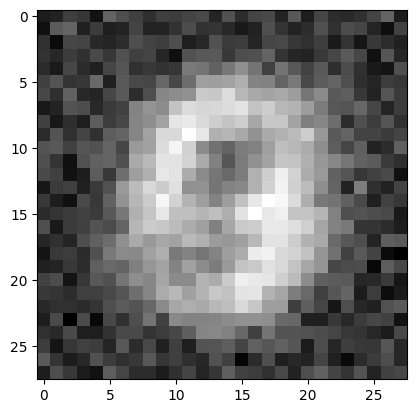

In [ ]:
#...
fake = g_net(1)
images = fake.detach().to('cpu').view(-1,1,28,28)
plt.imshow(images.squeeze(),cmap='gray')
plt.show()



# Transfer Learning

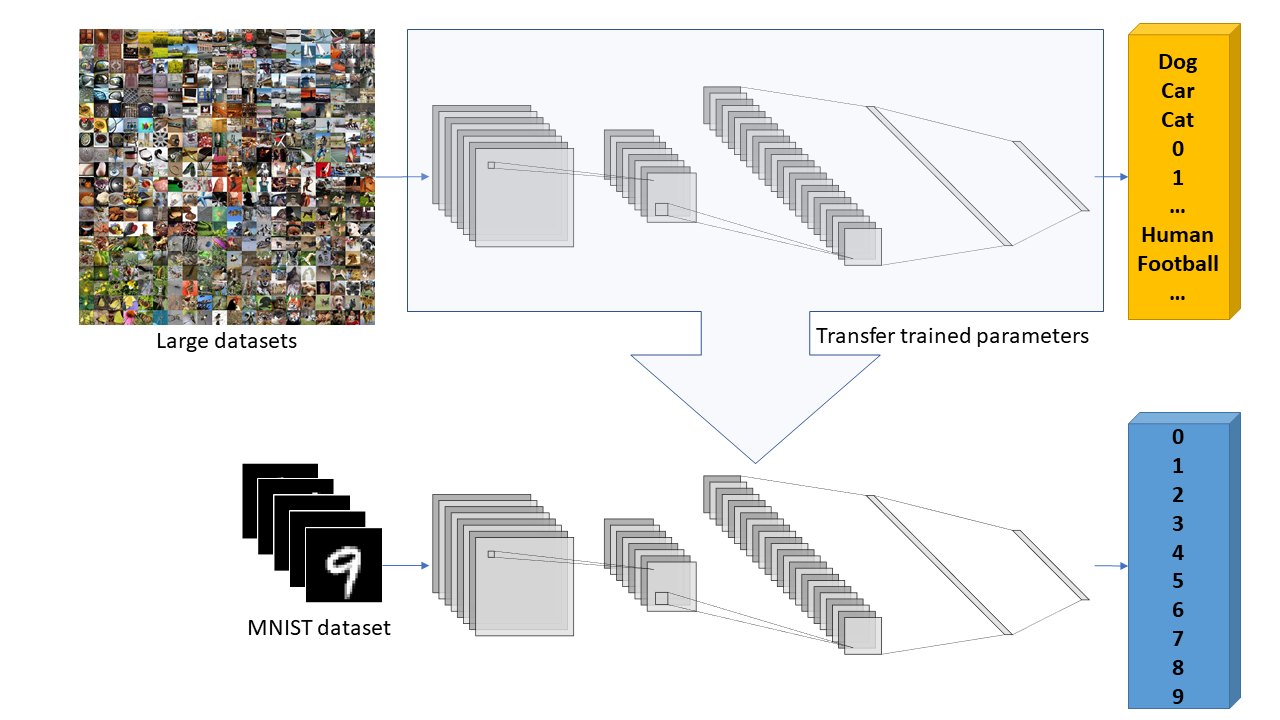

https://pytorch.org/vision/main/models.html

efficientnet

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

#...
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)




Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 73.6MB/s]


In [ ]:
#...
print(model.named_modules)


<bound method Module.named_modules of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
      

In [ ]:
#...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

The typical process of transfer learning involves freezing some base layers of a pre-trained model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [ ]:
#...
for param in model.parameters():
  param.requires_grad = False

summary(model, input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
#...
cifar10_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have 10 classes (`'airplane'`,`'automobile'`,`'bird'`,`'cat'`,`'deer'`,`'dog'`,`'frog'`,`'horse'`,`'ship'`,`'truck'`).

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

In [ ]:
#...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Ensure the entire model is on the correct device

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=10, bias=True) #input=1280 == default model
)

model.to(device) # Move the entire model to the device

summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

my model 653380120-2 sec.1 กัมแพงเพชร สิงห์ขรณ์

In [ ]:
#...
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=10, bias=True) #input=1280 == default model
)


In [ ]:
def train_model(
        dataloader,
        model,
        criterion = nn.CrossEntropyLoss(),
        lr = 0.001,
        epochs = 10,
        optimizer = optim.Adam,
        ):

    optimizer = optimizer(model.parameters(), lr=lr)
    model.to(device)
    model.train()

    for epoch in range(epochs):

      model_losses = []
      for images, labels in dataloader:
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(images)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          model_losses.append(loss.item())

      print(f"epoch:{epoch}, model loss:{np.mean(model_losses)}")


In [ ]:
def test_model(model, dataloader):
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for images, labels in dataloader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      print(f'Validation Accuracy: {100 * correct / total}%')

In [ ]:
train_model(
    dataloader = cifar10_train_dataloader,
    model = model
)

epoch:0, model loss:0.902931250993858
epoch:1, model loss:0.6991470541490619
epoch:2, model loss:0.6675255392747157
epoch:3, model loss:0.6557940912749761
epoch:4, model loss:0.6515600476652155
epoch:5, model loss:0.6400528822637275
epoch:6, model loss:0.6397183446018287
epoch:7, model loss:0.6422345791097797
epoch:8, model loss:0.6378046117551491
epoch:9, model loss:0.6360107006700447


In [ ]:
test_model(model, cifar10_test_dataloader)

Validation Accuracy: 81.7%
